<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

>>>>>>>>>>>>>> # Facebook Models

In [56]:
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
from tqdm import tqdm

from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

In [6]:
Dtrain = pd.read_csv('datasets/my/featured_train.csv',index_col=0)
Dtest = pd.read_csv('datasets/my/featured_test.csv',index_col=0)
Dtrain.shape,Dtest.shape

((100000, 55), (50000, 55))

* ### Preparing the data for model

In [11]:
Y_train = Dtrain['y']
Y_test = Dtest['y']
X_train = Dtrain.drop(['0','1','y'],axis=1)
X_test = Dtest.drop(['0','1','y'],axis=1)
Y_train.shape,X_train.shape,Y_test.shape,X_test.shape

((100000,), (100000, 52), (50000,), (50000, 52))

` Here we are going to use Test data as Cross_Validation data, we could have split data into three parts but it again could have caused more issues of new nodes (cold start). The real test data is the data model will get when it is deployed.`

- ### Here we will first fix "max_depth" and cross-validate "n_estimators"

100%|██████████| 12/12 [02:01<00:00, 10.10s/it]

 {10: 0.9014646708514407, 20: 0.9045643153526972, 50: 0.9070341733794873, 100: 0.9099673958658387, 150: 0.9095995351939918, 200: 0.9092143696310587, 400: 0.9098900151888917, 500: 0.9098193802707679, 600: 0.9097841540648829, 700: 0.909793953232877, 800: 0.9099658725117616, 1000: 0.9098191214470284} 
 {10: 0.9015803674675575, 20: 0.903837898171203, 50: 0.9065782676080592, 100: 0.9089345971156532, 150: 0.9088213809994413, 200: 0.9086878860266426, 400: 0.9093099812810638, 500: 0.9093060276212194, 600: 0.9092238857339529, 700: 0.9092551566902544, 800: 0.9093566622960686, 1000: 0.909255079006772}


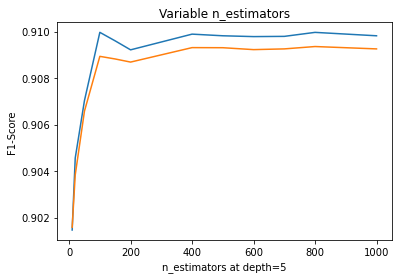

In [34]:
 n_est = [10,20,50,100,150,200,400,500,600,700,800,1000]
 train_scr = dict()
 test_scr = dict()

 for n in tqdm(n_est):
     clf = RandomForestClassifier(n_estimators=n,min_samples_split=120,min_samples_leaf=52,bootstrap=True,max_samples=0.75,max_depth=5,n_jobs=-1,random_state=25)
     clf.fit(X_train,Y_train)
     y_train_pred = clf.predict(X_train)
     y_test_pred = clf.predict(X_test)
     train_scr[n] = f1_score(Y_train,y_train_pred)
     test_scr[n] = f1_score(Y_test,y_test_pred)

print('\n',train_scr,'\n',test_scr)
print('='*30)

fig = plt.Figure(figsize=(7,7))
plt.plot(n_est,list(train_scr.values()))
plt.plot(n_est,list(test_scr.values()))
plt.xlabel("n_estimators")
plt.ylabel("F1-Score")
plt.title('score of variable n_estimators at depth=5')
plt.show()

- ### fixing "n_estimators" and cross-validate "max_depth"

100%|██████████| 7/7 [00:31<00:00,  4.53s/it]
 {5: 0.9102759911373071, 10: 0.9329520846035784, 20: 0.9425521732797902, 40: 0.9418453304455575, 60: 0.9418453304455575, 100: 0.9418453304455575, 125: 0.9418453304455575} 
 {5: 0.9093955406624565, 10: 0.9188144056092638, 20: 0.9201862039779941, 40: 0.9204723409658441, 60: 0.9204723409658441, 100: 0.9204723409658441, 125: 0.9204723409658441}



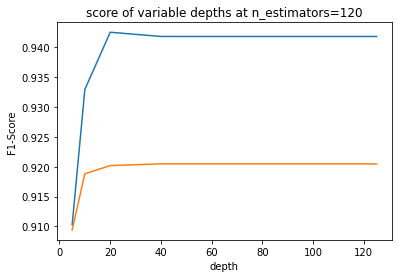

In [37]:
 depth = [5,10,20,40,60,100,125]
 train_scr = dict()
 test_scr = dict()

 for n in tqdm(depth):
     clf = RandomForestClassifier(n_estimators=120,min_samples_split=100,min_samples_leaf=50,bootstrap=True,max_samples=0.75,max_depth=n,n_jobs=-1,random_state=25)
     clf.fit(X_train,Y_train)
     y_train_pred = clf.predict(X_train)
     y_test_pred = clf.predict(X_test)
     train_scr[n] = f1_score(Y_train,y_train_pred)
     test_scr[n] = f1_score(Y_test,y_test_pred)

print('\n',train_scr,'\n',test_scr)
print('='*30)

fig = plt.Figure(figsize=(7,7))
plt.plot(depth,list(train_scr.values()))
plt.plot(depth,list(test_scr.values()))
plt.xlabel("depth")
plt.ylabel("F1-Score")
plt.title('score of variable depths at n_estimators=120')
plt.show()

In [21]:
clf = RandomForestClassifier(n_estimators=10,min_samples_split=100,min_samples_leaf=50,bootstrap=True,max_samples=0.75,max_depth=5,n_jobs=-1,random_state=25)
clf.fit(X_train,Y_train)
y_train_pred = clf.predict_proba(X_train)

In [26]:
y_train_pred[:,1]

100000

In [23]:
clf.predict(X_train)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

`Remember we are using RandomizedSearchCV so in params we cannot give an list but we have to give an distribution to choose from. And the 'randint' from scipy provides an uniform distribution. Learn more here:`  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html

In [43]:
params = dict(n_estimators=randint(90,125),
                max_depth = randint(15,25),
                min_samples_split= randint(110,190),
                min_samples_leaf= randint(25,65))
clf = RandomForestClassifier(bootstrap=True,max_samples=0.75,n_jobs=-1,random_state=25)
cv_clf = RandomizedSearchCV(clf,params,scoring='f1',n_jobs=-1,random_state=25)
cv_clf.fit(X_train,Y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(max_samples=0.75, n_jobs=-1,
                                                    random_state=25),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023595315CC8>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000235979D49C8>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023599921748>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023598144B08>},
                   random_state=25, scoring='f1')

In [52]:
print(cv_clf.cv_results_['mean_test_score'])
print('\n',cv_clf.best_score_)

[0.94017552 0.94275703 0.93714766 0.94212787 0.94429855 0.94182082
 0.94241701 0.93981973 0.93858962 0.94226153]

 0.9442985487847819


In [47]:
clf = cv_clf.best_estimator_

RandomForestClassifier(max_depth=19, max_samples=0.75, min_samples_leaf=28,
                       min_samples_split=111, n_estimators=112, n_jobs=-1,
                       random_state=25)

In [55]:
f1_train = f1_score(Y_train,cv_clf.best_estimator_.predict(X_train))
f1_test = f1_score(Y_test,cv_clf.best_estimator_.predict(X_test))
f1_train,f1_test

(0.9450567698279261, 0.9208496248546972)

In [82]:
C = confusion_matrix(Y_train,cv_clf.best_estimator_.predict(X_train))
precision_matrix = C/C.sum(axis=0)
recall_martix = (C.T/C.sum(axis=1)).T

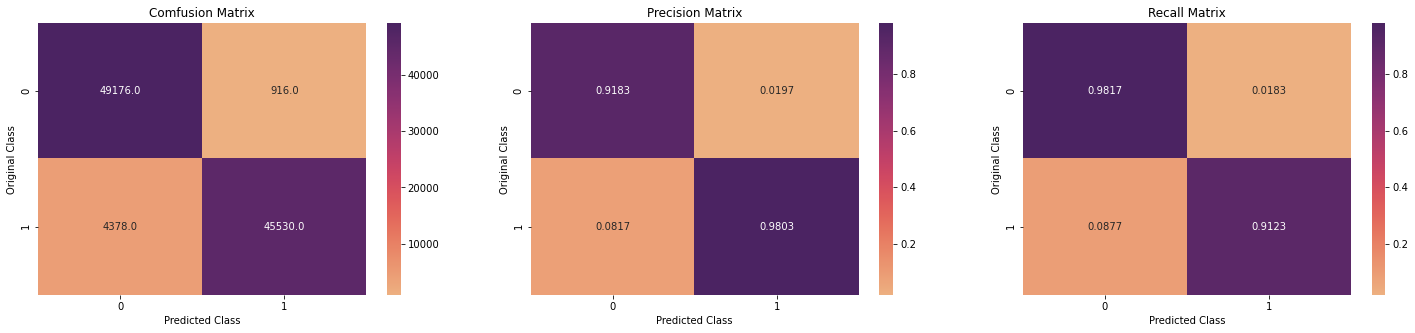

In [114]:
f = plt.figure(figsize=(25,5))
ax1 = plt.subplot(131)
sns.heatmap(C,annot=True,cmap='flare',fmt='.1f')
plt.title('Comfusion Matrix')
plt.xlabel("Predicted Class")
plt.ylabel("Original Class")

ax2 = plt.subplot(132)
sns.heatmap(precision_matrix,annot=True,cmap='flare',fmt='.4f')
plt.title('Precision Matrix')
plt.xlabel("Predicted Class")
plt.ylabel("Original Class")

ax3 = plt.subplot(133)
sns.heatmap(recall_martix,annot=True,cmap='flare',fmt='.4f')
plt.title('Recall Matrix')
plt.xlabel("Predicted Class")
_ = plt.ylabel("Original Class") # here as this is the last line of this cell the Jupyter displays some output, so using '_ =' we are suppressing it. 


In [134]:
feat_imporatances = dict(zip(list(X_train.columns),list(cv_clf.best_estimator_.feature_importances_)))
feat_imporatances = dict(sorted(feat_imporatances.items(), key=lambda item: item[1],reverse=True)) # sorting

<AxesSubplot:>

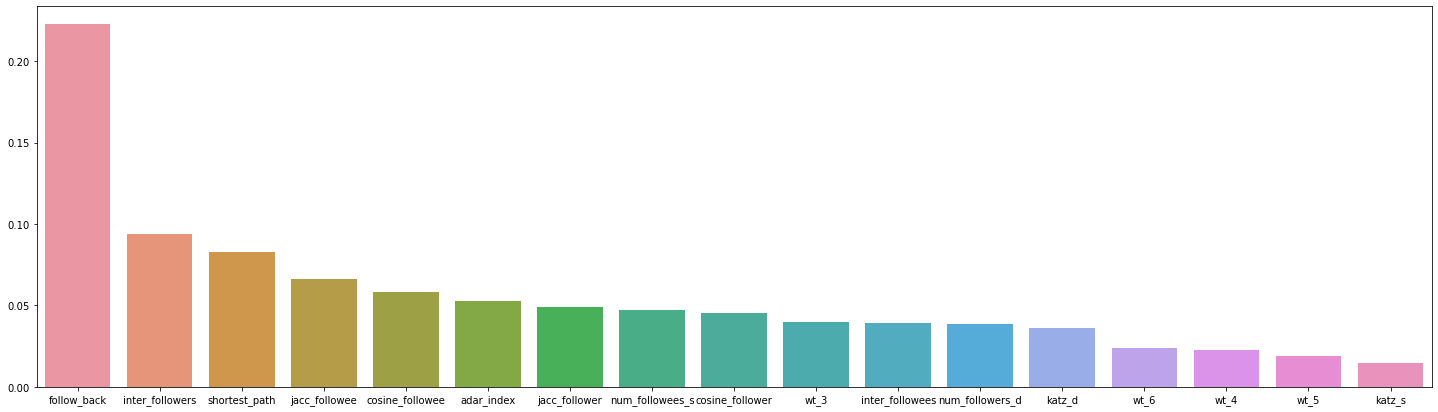

In [149]:
plt.figure(figsize=(25,7))
sns.barplot(list(feat_imporatances.keys())[:17],list(feat_imporatances.values())[:17])

<AxesSubplot:>

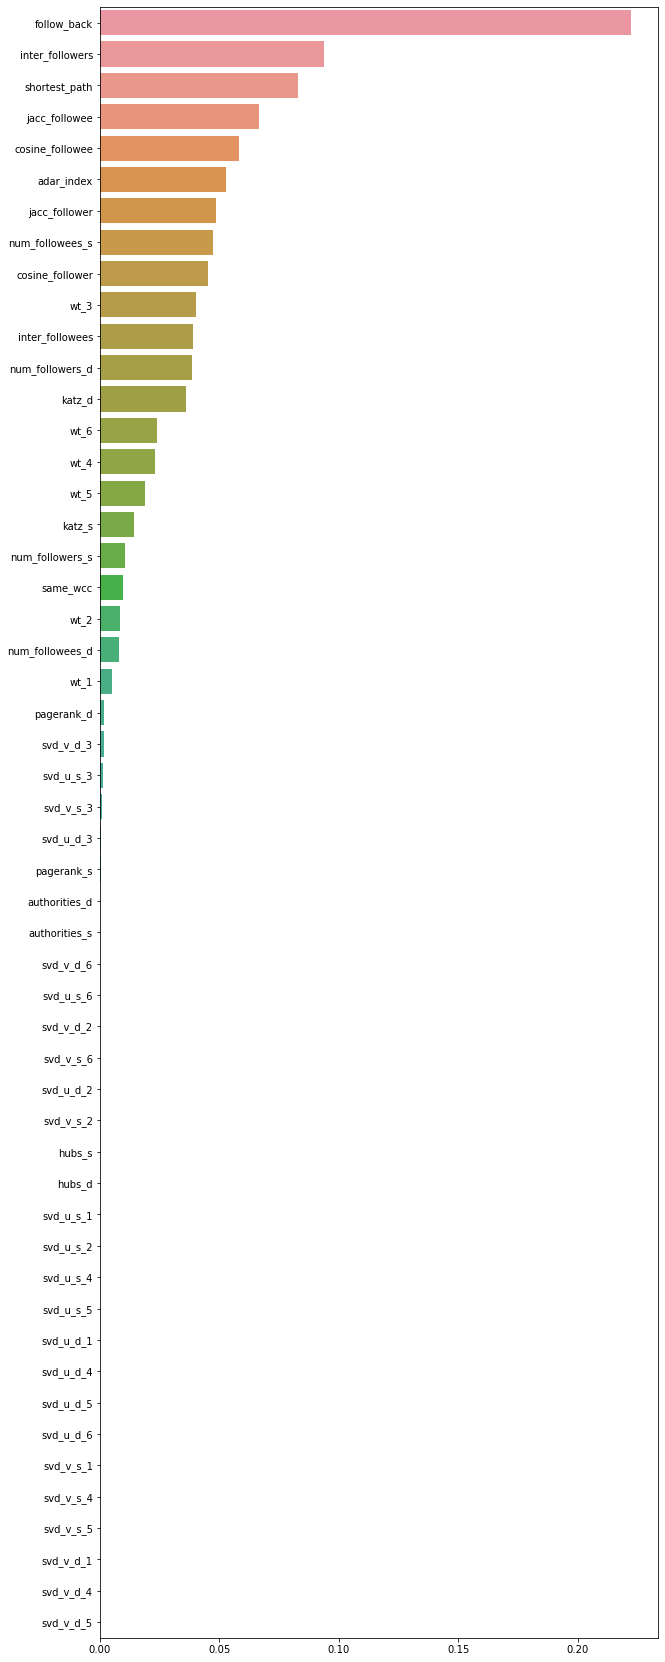

In [153]:
plt.figure(figsize=(10,30))
sns.barplot(list(feat_imporatances.values()),list(feat_imporatances.keys()))